# Character-level Language Model for Name Generation
Hello, welcome to my first transformer, a character level language model that generates names. It took me ~1.5 months of off-and-on work to make it happen.

At a high level, the model is tasked with predicting the next character in a name. Once it can do this, we can sample letters from the model one after the other and generate new names.

The dataset consists of 32033 names. I got the idea for this and the dataset from Andrej Karpathy's youtube tutorials which I found helpful. However, I want to make clear that I did this BEFORE he released his "GPT-style" tutorial (in which he does a project similar to this one)!!

Key takeways from the project
- ML models are hard to debug. The whole thing can run perfectly (no runtime errors) and still be wrong in many places. Make sure to start with the simplest model and the simplest dataset and scale up from there to ensure the whole thing works properly.
- ML models can be conceptually complicated while not requiring many lines of code. I tried to understand every part of the model before writing any code by writing some textbook-style explanations for myself. I took many breaks from the project (finals, winter break was happening) and constantly had to refer to my notes to remind myself of conceptual things and double check if my code was doing what it was supposed to. I would definitely recommend this.
- Torch's tensor operations were uncomfortable to use at first but I started to get the hang of it. I tried hard to avoid "for" loops when debugging or doing anything in favor of tensor operations. ".view()" is incredibly useful.
- Torch's Cross Entropy Loss calculation is weird

Basic imports, setting the device to use the gpu if possible.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
  device = torch.device("cuda") 
else:
  device = "cpu"
torch.cuda.get_device_name(device)

'Tesla T4'

Fetch Andrej Karpathy's names dataset.

In [2]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-01-20 23:42:03--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2023-01-20 23:42:03 (8.57 MB/s) - ‘names.txt’ saved [228145/228145]



Self attention layer implementations. I implemented a single-headed and multi-headed version, but only the multi-headed attention is used in the decoder.

The attention layers were the hardest to get right. At times the attention mechanism was privy to the information of the following characters in the sequence, which resulted in a model that could achieve very low loss while not being able to generate good names.

In [9]:
class SingleHeadAttention(torch.nn.Module):
  def __init__(self, model_dim, masked=False):
    super().__init__()
    self.model_dim = model_dim
    self.mask = masked

    # query, key, and value matrices. in the form of torch Linear layers
    self.QW = torch.nn.Linear(model_dim, model_dim, bias=False)
    self.KW = torch.nn.Linear(model_dim, model_dim, bias=False)
    self.VW = torch.nn.Linear(model_dim, model_dim, bias=False)

  def init_weights(self):
    torch.nn.init.xavier_uniform_(self.QW.weight)
    torch.nn.init.xavier_uniform_(self.KW.weight)
    torch.nn.init.xavier_uniform_(self.VW.weight)

  def forward(self, X):
    # X has shape (batch size, seqence len, model dim)
    Q = self.QW(X)
    K = self.KW(X)
    V = self.VW(X)
    
    # flip the last 2 dimensions 
    K_transpose = torch.transpose(K, 1, 2)

    score = (Q @ K_transpose) / np.sqrt(self.model_dim)

    if self.masked: 
      neg_inf = torch.full(size=score.size(), fill_value=-float("inf")).to(device)
      mask = torch.triu(neg_inf, diagonal=1).to(device)
      score += mask

    softmax = torch.nn.Softmax(dim=2)
    score_softmax = softmax(score)

    Z = score_softmax @ V
    return Z

class MultiHeadAttention(torch.nn.Module):
  def __init__(self, model_dim, heads, masked=False):
    super().__init__()
    self.model_dim = model_dim
    self.QW = torch.nn.Linear(model_dim, model_dim, bias=False)
    self.KW = torch.nn.Linear(model_dim, model_dim, bias=False)
    self.VW = torch.nn.Linear(model_dim, model_dim, bias=False)
    self.proj = torch.nn.Linear(model_dim, model_dim, bias=False)
    self.heads = heads 
    self.masked = masked

  def init_weights(self):
    torch.nn.init.xavier_uniform_(self.QW.weight)
    torch.nn.init.xavier_uniform_(self.KW.weight)
    torch.nn.init.xavier_uniform_(self.VW.weight)
    torch.nn.init.xavier_uniform_(self.proj.weight)
  
  def forward(self, X, X_enc=None):
    Q = self.QW(X)

    if X_enc is not None:
      K = self.KW(X_enc)
      V = self.VW(X_enc)
    else:
      K = self.KW(X)
      V = self.VW(X)

    # partition and reshape matrices based on heads
    # how does this work with masking?
    partition_len = int(self.model_dim / self.heads)
    batch_size = Q.size()[0]
    seq_len = Q.size()[1]
    # partitian last dimension into 2
    # stick remaining dimensionality into 2nd dimension
    # transpose so that 2nd dimension is heads
    Q = Q.view(batch_size, -1, self.heads, partition_len).transpose(1,2)
    K = K.view(batch_size, -1, self.heads, partition_len).transpose(1,2)
    V = V.view(batch_size, -1, self.heads, partition_len).transpose(1,2)

    # matmul will "broadcast" batch and head dimensions
    score = Q @ torch.transpose(K, 2, 3) / np.sqrt(self.model_dim)
    if self.masked: 
      neg_inf = torch.full(size=score.size(), fill_value=-float("inf")).to(device)
      mask = torch.triu(neg_inf, diagonal=1).to(device)
      score += mask

    softmax = torch.nn.Softmax(dim=3)
    score_softmax = softmax(score)
    
    Z = score_softmax @ V

    # undo partition
    Z = Z.transpose(1, 2).reshape(batch_size, -1, self.model_dim) 
    # final matrix multiplication, "projection"
    return self.proj(Z)

    # residual connection is handled in sublayer class

Positional embedding layer. It adjusts the input embeddings in a sequence to add positional information using a certain function.

In [4]:
class PositionEmbedding(torch.nn.Module): 
  def __init__(self, max_size=10000):
    super().__init__()
    self.max_size = max_size
        
  def forward(self, X):
    seq_len = X.size(dim=1)
    model_dim = X.size(dim=2)
    # self.pos_embed = np.array(shape=(seq_len, model_dim))
    pos_embed = torch.zeros(size=(seq_len, model_dim)).to(device)
    for pos in range(seq_len):
      for i in range(model_dim):
        pos_embed[pos][i] = np.sin( pos / ( self.max_size**( 2*i / model_dim ) ) )
    return X + pos_embed

Here we construct the datasets and dataloaders using torch.

In [10]:
import random
val_set_size = int(.1 * 32000)

class Vocab():
  def __init__(self, end_token=".", pad_token="#"): 
    # end token and start token are the same.
    self.end_token = end_token
    self.pad_token = pad_token

    words = open("names.txt","r").read().splitlines()
    chars = sorted(list(set("".join(words))))

    self.end_token_idx = len(chars)
    self.pad_token_idx = len(chars) + 1

    # maps characters to indices
    self.stoi = {s:i for i,s in enumerate(chars)}
    self.stoi[end_token] = self.end_token_idx
    self.stoi[pad_token] = self.pad_token_idx

    # maps indices to characters
    self.itos = {i:s for s,i in self.stoi.items()}
  
  def __len__(self):
    return len(self.stoi) 

vocab = Vocab()

class Names(torch.utils.data.Dataset):
  def __init__(self, train=True):
    self.words = open("names.txt","r").read().splitlines()
    random.shuffle(self.words)
    if train:
      self.words = self.words[:-1*val_set_size]
    else:
      self.words = self.words[-1*val_set_size:]
  
  def __len__(self):
    return len(self.words)
  
  def __getitem__(self, idx):
    word = self.words[idx]
    return [vocab.end_token_idx] + [vocab.stoi[i] for i in word] + [vocab.end_token_idx]

dataset_tr = Names(train=True)
dataset_val = Names(train=False)
print(f"train set len: {len(dataset_tr)}")
print(f"val set len: {len(dataset_val)}")

# just pads all sequences in batch to same length. 
# future: put small w small, large w large to minimize padding
def collate_fn(batch):
  max_len = max([len(seq) for seq in batch])
  for i in range(len(batch)):
    batch[i] += [vocab.pad_token_idx] * (max_len - len(batch[i]))
  
  return torch.tensor(batch)

dataloader_tr = torch.utils.data.DataLoader(
    dataset_tr, 
    batch_size=64,
    shuffle=True,
    collate_fn=collate_fn,
  )
dataloader_val = torch.utils.data.DataLoader(
    dataset_val, 
    batch_size=64,
    shuffle=True,
    collate_fn=collate_fn,
  )

train set len: 28833
val set len: 3200


Decoder and its building blocks called "sublayers."

In [11]:
#GPT-style decoder only tranformer architecture

class DecoderOnlySubLayer(torch.nn.Module):
  def __init__(self, model_dim, vocab_size, num_heads):
    super().__init__()
    self.model_dim = model_dim
    self.vocab_size = vocab_size


    # masked self attention
    self.attn = MultiHeadAttention(model_dim, num_heads, masked=True)
    self.norm1 = torch.nn.LayerNorm(model_dim)

    # feed forward
    ff_dim = 4 * model_dim # read that this was good setting
    self.ff1 = torch.nn.Linear(model_dim, ff_dim)
    # can use either one
    self.tanh = torch.nn.Tanh()
    self.relu = torch.nn.ReLU()
    self.ff2 = torch.nn.Linear(ff_dim, model_dim)
    self.norm2 = torch.nn.LayerNorm(model_dim)

  def forward(self, X):
    # X is shape (batch size, sequence length, model_dim)
    # self attention
    attn_out = self.attn(X)
    attn_out_normed = self.norm1(attn_out + X)

    # feed forward
    ff1_preact = self.ff1(attn_out_normed)
    ff1_out = self.tanh(ff1_preact)
    ff2_out = self.ff2(ff1_out)
    ff2_out_normed = self.norm2(ff2_out + attn_out_normed)
    return ff2_out_normed
  
  # initialization could be slightly improved using Kaiming initialization intead of Xavier
  def init_weights(self):
    self.attn.init_weights()
    torch.nn.init.xavier_uniform_(self.ff1.weight)
    torch.nn.init.zeros_(self.ff1.bias)
    torch.nn.init.xavier_uniform_(self.ff2.weight)
    torch.nn.init.zeros_(self.ff2.bias)
    torch.nn.init.ones_(self.norm1.weight)
    torch.nn.init.zeros_(self.norm1.bias)
    torch.nn.init.ones_(self.norm2.weight)
    torch.nn.init.zeros_(self.norm2.bias)

class DecoderOnly(torch.nn.Module):
  def __init__(self, model_dim, vocab_size, num_sublayers, num_heads):
    super().__init__()
    # this layer projects one hot encoded vectors of length=vocab_size to embeddings of length=model_dim.
    self.linear_embed = torch.nn.Linear(vocab_size, model_dim)
    self.pos_encode = PositionEmbedding()
    self.sublayers = torch.nn.ModuleList([DecoderOnlySubLayer(model_dim, vocab_size, num_heads) for _ in range(num_sublayers)])
    self.linear_out = torch.nn.Linear(model_dim, vocab_size)

  def forward(self, X):
    X_embed = self.linear_embed(X)
    X_pos_encoded = self.pos_encode(X_embed)

    sublayer_out = X_pos_encoded
    for sublayer in self.sublayers:
      sublayer_out = sublayer(sublayer_out)

    logits = self.linear_out(sublayer_out)
    return logits

  def init_weights(self):
    torch.nn.init.xavier_uniform_(self.linear_embed.weight)
    torch.nn.init.zeros_(self.linear_embed.bias)
    [sublayer.init_weights() for sublayer in self.sublayers]
    torch.nn.init.xavier_uniform_(self.linear_out.weight)
    torch.nn.init.zeros_(self.linear_out.bias)


epoch 0 (2.5740370433240667, 2.428519649505615)
epoch 1 (2.376777763641594, 2.3464225816726683)
epoch 2 (2.3150112713519855, 2.299526195526123)
epoch 3 (2.282283146999892, 2.282074251174927)
epoch 4 (2.2598500119608946, 2.2607011508941652)
epoch 5 (2.2428078492834933, 2.2371724462509155)
epoch 6 (2.2276446866883406, 2.2380037450790407)
epoch 7 (2.2156497147553775, 2.2281865072250366)
epoch 8 (2.204743119935503, 2.223374948501587)
epoch 9 (2.1945022521685074, 2.1873847389221193)
epoch 10 (2.1854777373125707, 2.1992902517318726)
epoch 11 (2.1773059785762543, 2.1858183002471923)
epoch 12 (2.169878699034122, 2.167123007774353)
epoch 13 (2.1628839816328163, 2.1612925052642824)
epoch 14 (2.156178038294722, 2.150251703262329)
epoch 15 (2.1500226341171436, 2.1561383056640624)
epoch 16 (2.144694895543439, 2.1494831657409668)
epoch 17 (2.1382485688922146, 2.1430498361587524)
epoch 18 (2.1333945672422185, 2.1360157251358034)
epoch 19 (2.1286525665524265, 2.131099810600281)
epoch 20 (2.12389288403

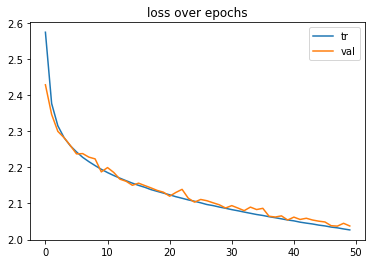

In [12]:
# model params
model_dim = 32 
num_sublayers = 4
num_heads = 8

# training params
lr = .03
epochs = 50

model = DecoderOnly(model_dim, len(vocab), num_sublayers, num_heads).to(device)
model.init_weights()

CE_loss = torch.nn.CrossEntropyLoss(ignore_index=vocab.pad_token_idx, reduction="mean").to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

losses = []
for epoch in range(epochs):
  losses_running_tr = []
  for batch_idx, batch in enumerate(dataloader_tr):
    # wtf does this do again?
    optimizer.zero_grad()

    # create one hot encodings from indices and chop off last character in each sequence (we can't predict past the last character)
    
    X = torch.nn.functional.one_hot(batch[:,:-1],num_classes=len(vocab)).float().to(device)

    # chop off first character in each sequence (the targets provide the correct character to be predicted.)
    Y = batch[:,1:].to(device)

    logits = model(X)

    # flatten everything for easy loss calculation (torch's CE loss implementation cannot handle such unflattened tensors)
    # the actual loss is a mean of all loss values.
    loss = CE_loss(logits.view(-1,len(vocab)), Y.view(-1))

    loss.backward()
    optimizer.step()

    losses_running_tr.append(loss.item())

  # ----------------------
  # validation

  losses_running_val = []
  with torch.no_grad():
    for batch_idx, batch in enumerate(dataloader_val):
      X = torch.nn.functional.one_hot(batch[:,:-1],num_classes=len(vocab)).float().to(device)
      Y = batch[:,1:].to(device)

      logits = model(X)

      loss = CE_loss(logits.view(-1,len(vocab)), Y.view(-1))

      losses_running_val.append(loss.item())

  losses.append((np.array(losses_running_tr).mean(),np.array(losses_running_val).mean()))  
  
  print(f"epoch {epoch} {losses[-1]}")

plt.plot(losses)
plt.legend(("tr","val"))
plt.title("loss over epochs")
plt.show()

Sample from the model to generate a batch of names!
- there are more complicated algorithms like beam search that might yield better results, I just used a simple greedy method here.

In [13]:
# generates batch of names by sampling from model
max_name_len = 15

softmax = torch.nn.Softmax(dim=2)
indices = torch.tensor([vocab.stoi["."]] * 64).view(64,1).to(device)
X = torch.nn.functional.one_hot(indices, len(vocab)).to(device)
with torch.no_grad():
  for i in range(max_name_len):
    X = torch.nn.functional.one_hot(indices, len(vocab)).float().to(device)

    logits = model(X)
    probs = softmax(logits)
    
    samples = torch.multinomial(probs[:,-1,:].view(64, -1), 1, replacement=True)
    indices = torch.concat((indices, samples),dim=1)

for i in range(indices.shape[0]):
  s = ""
  for j in range(1,indices.shape[1]):
    char = vocab.itos[indices[i][j].item()]
    if char == ".":
      break
    s += char
  print(s)

kaseri
hanna
zeve
tyneli
matcy
durianza
mikris
lorani
rhily
taisem
vingei
anaya
baryon
chritlei
khasima
alizie
ariyah
schaft
lealton
graret
deni#ion
riyase
xahael
maravion
jeravioh
naahm
adyya
jarmanie
sahyla
rozlin
ellyne
kyleanie
kinna
cyour
quanson
chansopomus
natana
jordo
keluber
hira
zohim
bark
lanna
tayisa
kessin
yerina
khreen
losvie
mckly
sorei
saninyah
breley
makenlie
aviya
haime
kainon
audra
mariah
jayavia
anio
won
coub

jerem


Autocomplete any name!
- make sure to put the start/end token "." at the beginning

In [27]:
s = ".emm"

softmax = torch.nn.Softmax(dim=2)
seq = torch.tensor([vocab.stoi[i] for i in s]).to(device)
with torch.no_grad():
  while not (seq[-1] == vocab.end_token_idx and len(seq) > 1):
    X = torch.nn.functional.one_hot(seq.view(1,-1),num_classes=len(vocab)).float().to(device)

    logits = model(X)

    probs = softmax(logits)[0,seq.size(dim=0)-1]

    sample = torch.multinomial(probs, 1, replacement=True)

    seq = torch.concat((seq, sample))

  chars = [vocab.itos[i.item()] for i in seq]
  print("".join(chars[1:-1]))

emmerie
